In [1]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-005-000-010.root"

In [2]:
import time
import os
from mu2etools import *
from mu2etools import wideband

In [3]:
processor = wideband.DataProcessor(usexroot=True,
                                   fixtimes=False,
                                   treename='run', 
                                   filter_name=['PEs', 'timeSinceSpill', 'spillNumber', 'eventNumber'],
                                   runlist=[1635], userunlist=True, remove=False
                                  )
ar = processor.getData(DATASET)
hep.style.use('ATLAS')  # or ATLAS/LHCb2

Text(1, 0, 'PEs')

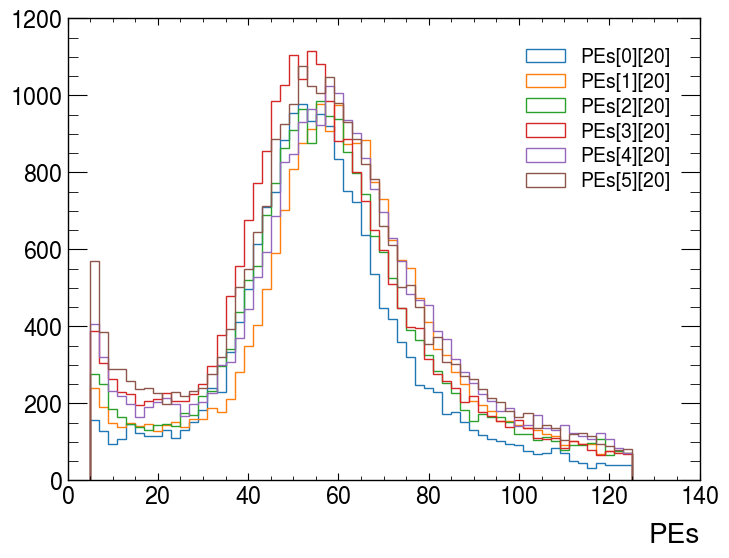

In [4]:
for feb in range(0,6):
  plt.hist(ar['PEs'][:,feb,20], histtype='step', bins=60, range=[5, 125], label='PEs[%d][20]'%feb);
plt.legend()
plt.xlabel('PEs')

In [5]:
#Mask layers in the trigger modules above the 10 PE threshold
FEB0_0 = (ak.sum(ar['PEs'][:,0,0:32], axis=-1)>10)
FEB0_1 = (ak.sum(ar['PEs'][:,0,32:64], axis=-1)>10)

FEB1_0 = (ak.sum(ar['PEs'][:,1,0:32], axis=-1)>10)
FEB1_1 = (ak.sum(ar['PEs'][:,1,32:64], axis=-1)>10)

FEB2_0 = (ak.sum(ar['PEs'][:,2,0:32], axis=-1)>10)
FEB2_1 = (ak.sum(ar['PEs'][:,2,32:64], axis=-1)>10)

FEB5_0 = (ak.sum(ar['PEs'][:,5,0:32], axis=-1)>10)
FEB5_1 = (ak.sum(ar['PEs'][:,5,32:64], axis=-1)>10)

arr_clean = ar[FEB0_0 & FEB0_1 & FEB1_0 & FEB1_1 & FEB2_0 & FEB2_1 & FEB5_0 & FEB5_1]

In [6]:
#Mask layers in the test module above the 10 PE threshold
FEB3_0 = (ak.sum(arr_clean['PEs'][:,3,0:32], axis=-1)>10)
FEB3_1 = (ak.sum(arr_clean['PEs'][:,3,32:64], axis=-1)>10)

FEB4_0 = (ak.sum(arr_clean['PEs'][:,4,0:32], axis=-1)>10)
FEB4_1 = (ak.sum(arr_clean['PEs'][:,4,32:64], axis=-1)>10)

In [7]:
nHits = ak.values_astype(FEB3_0, "int")+ \
       ak.values_astype(FEB3_1, "int")+ \
       ak.values_astype(FEB4_0, "int")+ \
       ak.values_astype(FEB4_1, "int")

In [8]:
nPass = ak.count(arr_clean[(nHits==4) | (nHits==3)]['eventNumber'])
nTrig = ak.count(arr_clean['eventNumber'])
print('3-4 efficiency: %.2f'%(nPass/nTrig*100))

3-4 efficiency: 99.96


In [9]:
nPass = ak.count(arr_clean[(nHits==4)]['eventNumber'])
nTrig = ak.count(arr_clean['eventNumber'])
print('4-4 efficiency: %.2f'%(nPass/nTrig*100))

4-4 efficiency: 98.52


Text(1, 0, 'nHits')

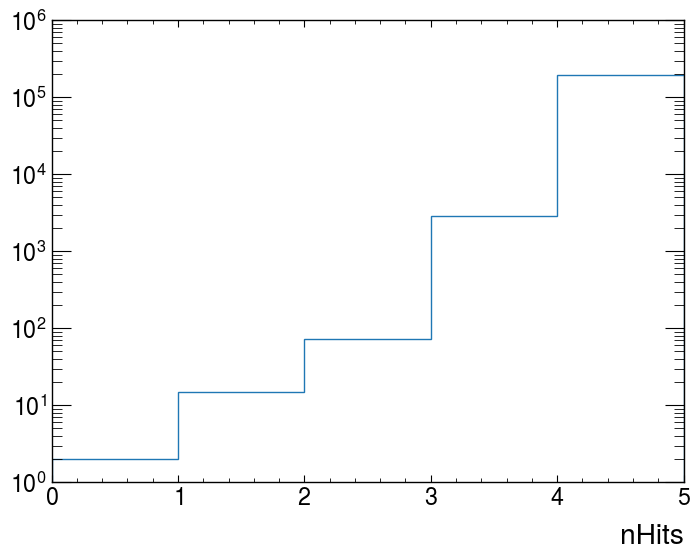

In [10]:
plt.hist(nHits, histtype='step', bins=5, range=(0,5));
plt.yscale('log')
plt.xlabel('nHits')

In [12]:
#Failed events with only one hit in CRV
arr_clean[(nHits==1)]

<Array [{spillNumber: 58, ...}, ..., {...}] type='15 * {spillNumber: int32,...'>